In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from vae.conv_vae import CVAE

## I. Data reading & processing

#### 1. Read data

In [2]:
# Load Fashion-MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#### 2. Define class names 

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### 3. Explore images

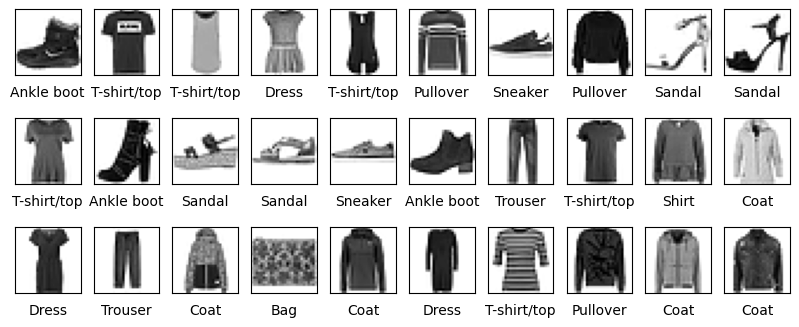

In [4]:
plt.figure(figsize=(10,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

#### 4. Data normalization 

- Normalize pixel values to be between 0 and 1

In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

#### 5 Adding a dimension with a single element

In [6]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

## II. VAE training

#### 1. Define model parameters

In [7]:
# Image shape
nrows = train_images.shape[1]
ncols = train_images.shape[2]
# Latent space dimension
latent_dim = 2
# Learning rate
lr = 5e-3

#### 2. Create model

The coefficients associated with KL-divergence and reconstruction binary cross-entropy can be modified through the VariationalLossLayer class in constructor **loss_weights** parameter (vae/variation_loss_layer.py):
- KL-Divergence coefficient: **1e-2**
- Reconstruction binary cross-entropy coefficient: **1**

In [8]:
model = CVAE(nrows, ncols, latent_dim)

In [9]:
model.compile(lr = lr)

In [10]:
model.model.summary()

Model: "CVAE-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   832         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 32)     0           ['conv2d_1[0][0]']               
                                                                                         

#### 3. Training the model

- Define the EarlyStopping callback

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
model.fit(train_images, train_images, 
          test_images, test_images,
          early_stop,
          64, 30)

Epoch 1/30
938/938 [==============================] - 68s 71ms/step - loss: 0.3638 - r_loss: 0.3597 - kl_loss: 4.1000 - val_loss: 0.3590 - val_r_loss: 0.3556 - val_kl_loss: 3.4245
Epoch 2/30
938/938 [==============================] - 68s 72ms/step - loss: 0.3488 - r_loss: 0.3453 - kl_loss: 3.5324 - val_loss: 0.3494 - val_r_loss: 0.3463 - val_kl_loss: 3.1195
Epoch 3/30
938/938 [==============================] - 66s 71ms/step - loss: 0.3455 - r_loss: 0.3421 - kl_loss: 3.4555 - val_loss: 0.3438 - val_r_loss: 0.3405 - val_kl_loss: 3.2941
Epoch 4/30
938/938 [==============================] - 68s 72ms/step - loss: 0.3443 - r_loss: 0.3409 - kl_loss: 3.4622 - val_loss: 0.3435 - val_r_loss: 0.3400 - val_kl_loss: 3.5348
Epoch 5/30
938/938 [==============================] - 65s 69ms/step - loss: 0.3433 - r_loss: 0.3399 - kl_loss: 3.4714 - val_loss: 0.3444 - val_r_loss: 0.3409 - val_kl_loss: 3.4716
Epoch 6/30
938/938 [==============================] - 66s 70ms/step - loss: 0.3425 - r_loss: 0.3390 

#### 4. Loss function during training

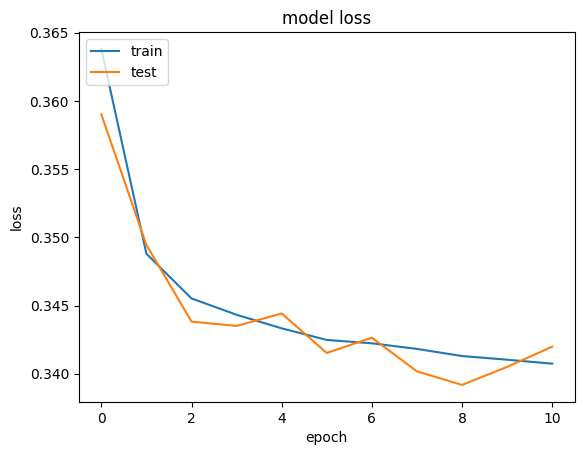

In [23]:
history = model.trained
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## III. Exploiting reusults

#### 1. Test reconstructions

In [24]:
pred = model.model.predict(test_images)
pred = pred.reshape((test_images.shape[0], 28, 28))

313/313 [==============================] - 3s 10ms/step


#### 2. Visualize reconstructions

- Original

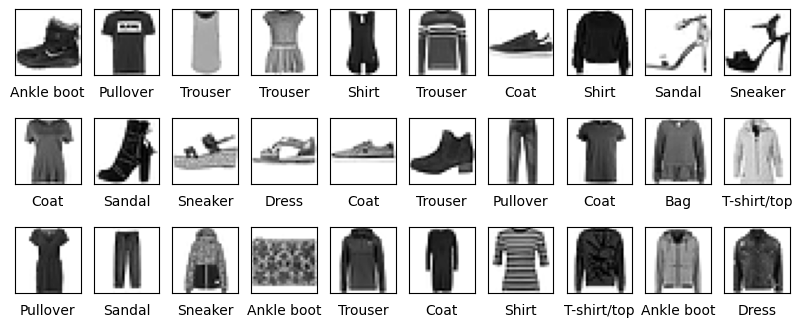

In [25]:
plt.figure(figsize=(10,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
plt.show()

- Reconstructions

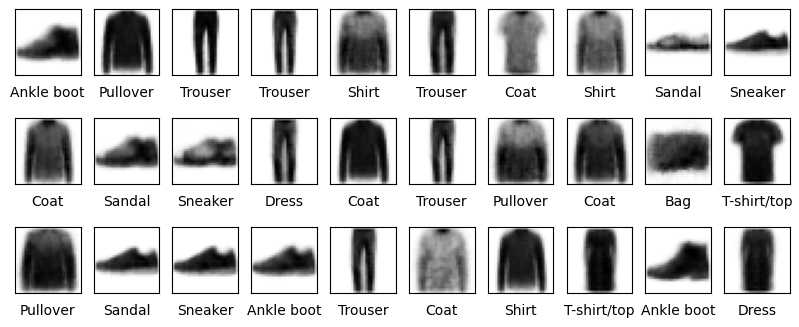

In [26]:
plt.figure(figsize=(10,4))
for i in range(30):
    plt.subplot(3,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(pred[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
plt.show()

#### 3. Visualize latent space

- Encoder projections:

In [27]:
mean, log_var, z = model.encoder.predict(test_images)
mean = pd.DataFrame(mean, columns = ['latent_1', 'latent_2'])
mean['label'] = [class_names[i] for i in test_labels]

313/313 [==============================] - 1s 4ms/step


- Display latent space

In [28]:
fig = px.scatter(mean, 'latent_1', 'latent_2', 'label').update_traces(marker=dict(size=4))

- Create a grid in latent space [-2, 2] * [-2, 2]

In [29]:
# Define the size of the grid and the range of the latent space
num_steps = 20
latent_range = 3

# Generate a grid of points in the latent space
points = np.linspace(-latent_range, latent_range, num_steps)
grid = np.meshgrid(points, points)
grid = np.array(grid)
grid2 = grid.reshape(2, -1).T

- Visualize the grid in latent space

In [30]:
new_trace = go.Scatter(
    x=grid2[:, 0],
    y=grid2[:, 1],
    mode="markers",
    name="GRID",
    line={'color': 'black'}
)
fig.add_trace(new_trace)

- Decoding grid latent vectors (100*2)

In [21]:
reconstructions = model.decoder.predict(grid2)
reconstructions = reconstructions.reshape((reconstructions.shape[0], 28, 28))

13/13 [==============================] - 0s 9ms/step


- Displaying the grid reconstructions

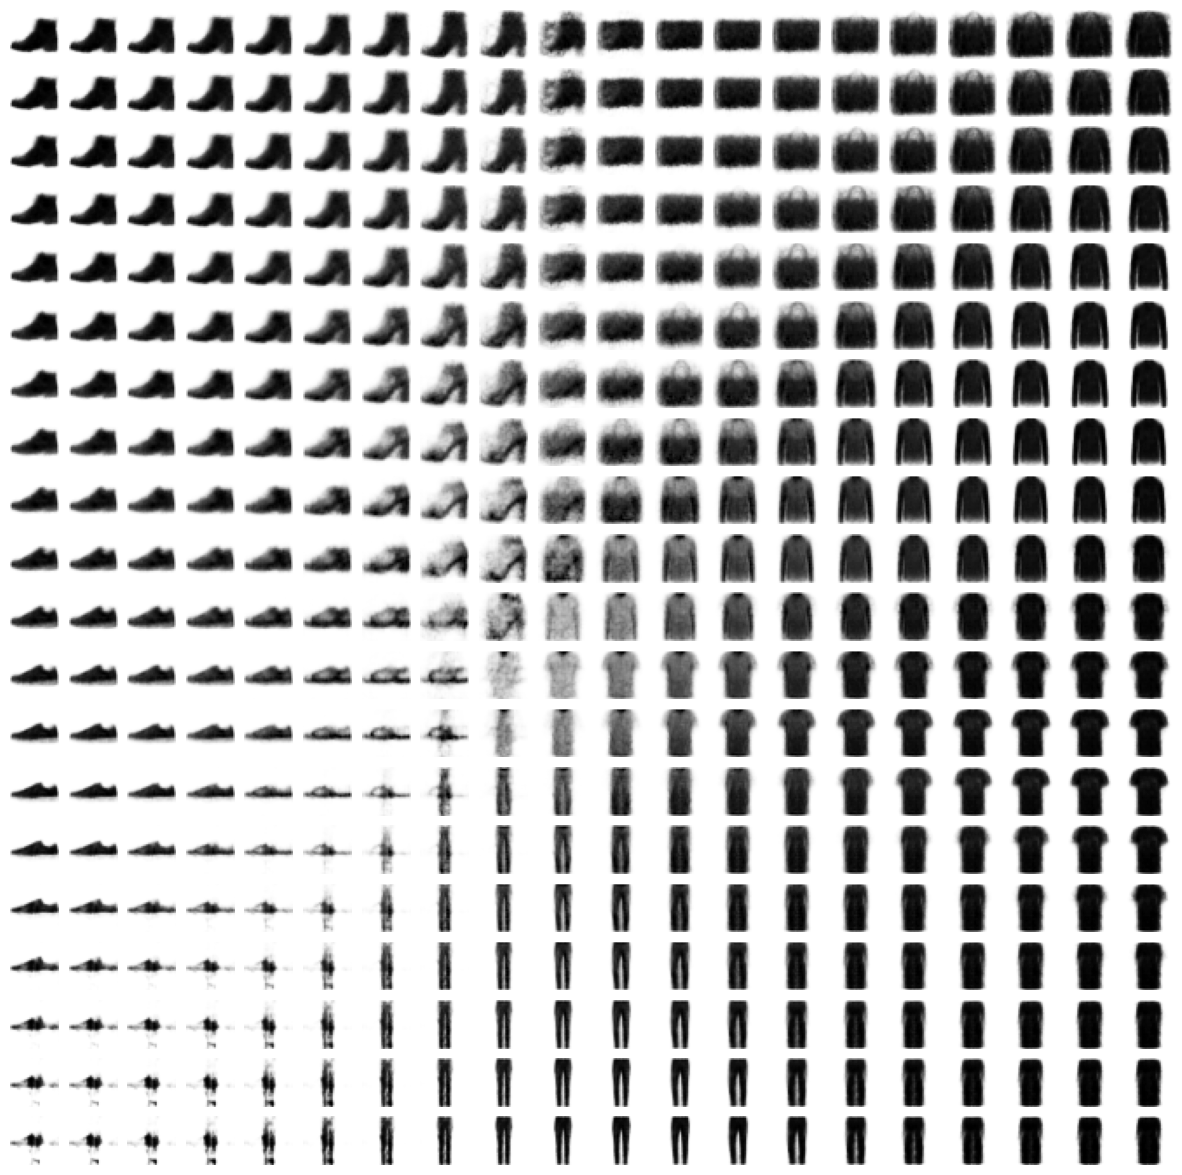

In [22]:
fig, axs = plt.subplots(num_steps, num_steps, figsize=(15, 15))

for i in range(num_steps):
    for j in range(num_steps):
        idx = (num_steps-i-1) * num_steps + j
        axs[i, j].imshow(reconstructions[idx].reshape(28, 28), cmap=plt.cm.binary)
        axs[i, j].axis('off')
        #axs[i, j].set_title(f'{round(grid[0, num_steps-i-1, j], 2)}, {round(grid[1, num_steps-i-1, j], 2)}', fontsize=7)

plt.show()

## IV. Conclusion

- Through VAE we projected the images into a continuous 2D space of distributions.
- The latent space can be decoded into FASHION-MNIST similar images.
- The latent space is clustered into the sub-categories of objects.
- The result can either favor reconstruction quality or KL-Divergence normal distribution enforcing. This can be controlled using the corresponding loss function's coefficients.